In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from glob import glob
import matplotlib.pyplot as plt
from collections import Counter
import torch
import tarfile
import os

import numpy as np
import zarr

from tqdm import tqdm, trange


from pathlib import Path
from furniture_bench.robot.robot_state import filter_and_concat_robot_state
from furniture_bench.perception.image_utils import resize_crop

from vip import load_vip
from r3m import load_r3m


import itertools
import math
from ipdb import set_trace as st

from src.models.vision import R3MEncoder

/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
root = Path("/home/larsankile/furniture-diffusion/data/")
randomness = "low"
furniture = "one_leg"
extension = ".tar.gz"
obs_type = "image"
env_type = "real"
filename = furniture + extension


input_file = root / "raw" / env_type / obs_type / randomness / filename
output_file = (
    root / "processed" / env_type / obs_type / randomness / furniture / "data.zarr"
)

In [ ]:
max_samples = 200

raw_data, n_samples = [], 0
with tarfile.open(input_file, "r:gz") as tar:
    for member in tqdm(tar, desc=f"Extracting {furniture}", total=max_samples):
        if (
            member.isfile() and ".pkl" in member.name
        ):  # Replace 'your_condition' with actual condition
            with tar.extractfile(member) as f:
                if f is not None:
                    content = f.read()
                    data = pickle.loads(content)
                    raw_data.append(data)
                    n_samples += 1

                    if n_samples >= max_samples:
                        break

In [5]:
input_dir = Path("/home/larsankile/furniture-diffusion/data/raw/sim/full/one_leg/low")
output_file = Path(
    "/home/larsankile/furniture-diffusion/data/processed/sim/image/low/one_leg/data.zarr"
)

In [38]:
files = list(input_dir.rglob("**/*.pkl"))

raw_data = []

for file in tqdm(files):
    with open(file, "rb") as f:
        data = pickle.load(f)
        raw_data.append(data)

100%|██████████| 94/94 [00:03<00:00, 30.14it/s]


## Extract features

In [ ]:
vip = load_vip(device_id=1).module

vip.device

In [3]:
def get_features(img_batch, encoder):
    with torch.no_grad():
        img_tensor = torch.tensor(
            img_batch, dtype=torch.float32, device=encoder.device
        ).permute(0, 3, 1, 2)
        features = encoder(img_tensor).cpu().numpy()
    return features

In [ ]:
batch_size = 256
observations = []
actions = []
episode_ends = []

end_index = 0

for data in tqdm(raw_data):
    img1_batch = []
    img2_batch = []
    for obs, action in zip(data["observations"], data["actions"]):
        robot_state = filter_and_concat_robot_state(obs["robot_state"])

        img1_batch.append(obs["color_image1"])
        img2_batch.append(obs["color_image2"])

        actions.append(action)

        if len(img1_batch) == batch_size:
            img1_features = get_features(np.stack(img1_batch, axis=0))
            img2_features = get_features(np.stack(img2_batch, axis=0))

            for f1, f2 in zip(img1_features, img2_features):
                observation = np.concatenate((robot_state, f1, f2))
                observations.append(observation)

            img1_batch = []
            img2_batch = []

        end_index += 1

    # Handle any remaining images within each trajectory
    if img1_batch:
        img1_features = get_features(np.stack(img1_batch, axis=0))
        img2_features = get_features(np.stack(img2_batch, axis=0))

        for f1, f2 in zip(img1_features, img2_features):
            observation = np.concatenate((robot_state, f1, f2))
            observations.append(observation)

    episode_ends.append(end_index)

observations = np.array(observations)
actions = np.array(actions)
episode_ends = np.array(episode_ends)

In [ ]:
zarr.save(
    output_file,
    observations=observations,
    actions=actions,
    episode_ends=episode_ends,
)

### Convert existing zarr image dataset to feature dataset

In [4]:
input_file = Path(
    "/home/larsankile/furniture-diffusion/data/processed/sim/image/low/one_leg/data.zarr"
)
output_file = Path(
    "/home/larsankile/furniture-diffusion/data/processed/sim/feature/dino/low/one_leg/data.zarr"
)

data = zarr.open(input_file)

In [1]:
encoder = DinoEncoder()

NameError: name 'DinoEncoder' is not defined

In [6]:
len(data["image1"]), len(data["image2"]), len(data["agent_pos"])

(45876, 45876, 45876)

In [7]:
batch_size = 512
feat1_batches = []
feat2_batches = []

for i in trange(0, len(data["image1"]), batch_size):
    img1_features = get_features(data["image1"][i : i + batch_size], encoder)
    img2_features = get_features(data["image2"][i : i + batch_size], encoder)

    feat1_batches.append(img1_features)
    feat2_batches.append(img2_features)

feat1 = np.concatenate(feat1_batches, axis=0)
feat2 = np.concatenate(feat2_batches, axis=0)

# Concatenate features with robot state
agent_pos = data["agent_pos"][:]
observations = np.concatenate((agent_pos, feat1, feat2), axis=1)

zarr.save(
    output_file,
    observations=observations,
    actions=data["actions"][:],
    episode_ends=data["episode_ends"][:],
)

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [18:55<00:00, 12.61s/it]


## Extract and resize the images

In [39]:
agent_pos = []
image1 = []
image2 = []
actions = []
episode_ends = []


for data in tqdm(raw_data):
    img1_batch = []
    img2_batch = []
    for agent_pos, image1, image2 in zip(data["observations"], data["actions"]):
        robot_state = filter_and_concat_robot_state(obs["robot_state"])
        agent_pos.append(robot_state)

        img1 = obs["color_image1"]
        img2 = obs["color_image2"]

        if img1.shape != (224, 224, 3):
            img1 = resize_crop(img1)
            img2 = resize_crop(img2)

        image1.append(img1)
        image2.append(img2)

        actions.append(action)

        end_index += 1

    episode_ends.append(end_index)

agent_pos = np.array(agent_pos)
image1 = np.array(image1)
image2 = np.array(image2)
actions = np.array(actions)
episode_ends = np.array(episode_ends)

agent_pos.shape, image1.shape, image2.shape, actions.shape, episode_ends.shape

100%|██████████| 94/94 [00:00<00:00, 533.03it/s]


((45876, 14), (45876, 224, 224, 3), (45876, 224, 224, 3), (45876, 8), (94,))

In [40]:
output_file

PosixPath('/home/larsankile/furniture-diffusion/data/processed/sim/image/low/one_leg/data.zarr')

In [41]:
zarr.save(
    output_file,
    agent_pos=agent_pos,
    image1=image1,
    image2=image2,
    actions=actions,
    episode_ends=episode_ends,
)

In [31]:
enc = R3MEncoder(device="cuda:1")

enc.device

'cuda:1'

In [33]:
enc(torch.randn(1, 224, 224, 3).cuda(1)).shape

torch.Size([1, 2048])

In [35]:
# Get embedding dim
enc.encoding_dim

2048

In [ ]:
# Make a smaller version of the dataset for testing
orignal_file = (
    Path(os.environ["FURNITURE_DATA_DIR"])
    / "processed"
    / "sim"
    / "image"
    / "one_leg"
    / "high"
    / "data.zarr"
)

## Double check that the new sim scripted demos are looking alright

In [10]:
with open(
    "/data/scratch/ankile/test-scripted-demo/cabinet/2024-01-04-08:14:52/2024-01-04-08:14:52.pkl",
    "rb",
) as f:
    data = pickle.load(f)

data.keys()

dict_keys(['observations', 'actions', 'rewards', 'skills', 'success', 'furniture', 'error', 'error_description'])

In [11]:
data["observations"][0]["color_image1"].shape, data["observations"][0][
    "color_image2"
].shape

((224, 224, 3), (224, 224, 3))

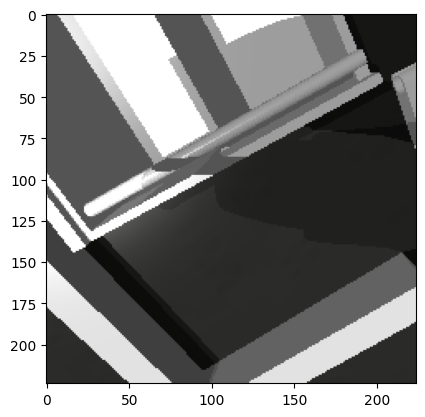

In [15]:
# Show the images
plt.imshow(data["observations"][0]["color_image1"])

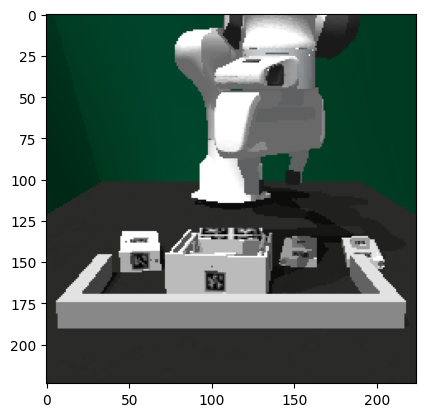

In [13]:
plt.imshow(data["observations"][0]["color_image2"])

In [22]:
from src.visualization.render_mp4 import create_mp4

In [24]:
vid1 = np.array([obs["color_image1"] for obs in data["observations"]])
vid2 = np.array([obs["color_image2"] for obs in data["observations"]])

vid = np.concatenate((vid1, vid2), axis=2)

In [25]:
create_mp4(vid, "test.mp4")

100%|██████████| 870/870 [00:00<00:00, 1134.04it/s]

File saved as test.mp4


## Look at the newly (January 12, 2024) collected demos

In [3]:
from src.visualization.render_mp4 import mp4_from_pickle, create_mp4

### One leg

In [4]:
demo_base = Path(os.environ["ROLLOUT_SAVE_DIR"]) / "raw" / "sim" / "one_leg"
paths = [path for path in demo_base.rglob("*.pkl")]

len(paths)

718

In [5]:
# Open one and see what it looks like
with open(paths[0], "rb") as f:
    data = pickle.load(f)

data.keys()

dict_keys(['observations', 'actions', 'rewards', 'skills', 'success', 'furniture', 'error', 'error_description'])

In [6]:
data["observations"][0].keys()

dict_keys(['color_image1', 'color_image2', 'robot_state', 'parts_poses'])

### Lamp

In [7]:
randomness = "low"  # low, med, high

demo_base = (
    Path(os.environ["ROLLOUT_SAVE_DIR"]) / "raw" / "sim" / "lamp"
)  # / randomness
paths = [path for path in demo_base.rglob("*.pkl")]

len(paths)

440

In [54]:
mp4_from_pickle(paths[0], f"test_lamp_{randomness}.mp4")









100%|██████████| 721/721 [00:00<00:00, 967.46it/s] 

File saved as test_lamp_low.mp4


In [33]:
# Go through the demo and look for noops
noops = []

for action in data["actions"]:
    print(list(action))
    if np.allclose(action[:-1], np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])):
        noops.append(action)

len(noops)

[-0.113328874, -0.0027341843, 0.0, -0.012054026, 0.010560537, -0.4492338, -0.8932704, -1.0]
[-0.11959309, -0.0017164573, 0.0, -0.0114328265, 0.0076331953, -0.44147107, -0.8971701, -1.0]
[-0.11461881, 0.0020392165, 0.0, -0.009903014, -0.0026821755, -0.41239485, -0.9109475, -1.0]
[-0.11241559, 0.0063038543, 0.0, -0.0096187, -0.013405319, -0.3566846, -0.9340792, -1.0]
[-0.11281622, 0.008469164, 0.0, -0.010456741, -0.020493627, -0.29625756, -0.95483094, -1.0]
[-0.053037092, 0.008627206, 0.0, -0.0117355585, -0.02402391, -0.23759535, -0.9709961, -1.0]
[-0.0034959912, 0.009967767, 0.0, -0.013912141, -0.028620489, -0.19354567, -0.9805749, -1.0]
[0.009651184, 0.011747532, 0.0, -0.015072882, -0.031115474, -0.17405622, -0.9841286, -1.0]
[0.008046448, 0.010622628, 0.0, -0.015051603, -0.03009284, -0.15222017, -0.9877738, -1.0]
[0.0047712326, 0.007509306, 0.0, -0.013734341, -0.027349057, -0.12361528, -0.9918582, -1.0]
[0.0016175508, 0.004172936, 0.0, -0.0116404295, -0.023463462, -0.09635795, -0.9950

1

### Round table

In [8]:
demo_base = (
    Path(os.environ["ROLLOUT_SAVE_DIR"]) / "raw" / "sim" / "round_table" / "high"
)
paths = [path for path in demo_base.rglob("*.pkl")]

len(paths)

396

In [82]:
mp4_from_pickle(paths[1], "round_table_high.mp4")













100%|██████████| 1039/1039 [00:01<00:00, 864.10it/s]


File saved as round_table_high.mp4


In [39]:
# Go through the demo and look for noops
noops = []

for i, action in enumerate(data["actions"]):
    if np.allclose(action[:-1], np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])):
        noops.append((i, action))

len(noops), noops[0][0]

(1, 471)